# Bob Ross Paintings Segmentation with UNet

Training a UNet to segment different classes from Bob Ross paintings using the [Kaggle's dataset](https://www.kaggle.com/residentmario/segmented-bob-ross-images).

In [ ]:
%%capture
!pip install ipdb
import random
import ipdb
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score as iou

import torch
from torch import nn
from torch import optim
import torch.functional as F
from torchvision.models import mobilenet_v2
from torchvision import transforms as T

torch.manual_seed(23)
np.random.seed(23)

### Download the [dataset](https://www.kaggle.com/residentmario/segmented-bob-ross-images)

In order to download the dataset, put your [kaggle.json](https://kaggle.com) credentials file in the colab content folder.

In [2]:
%%capture
import os

if os.path.isdir('segmented-bob-ross-images'):
  # break cell execution - fun doesn't exist
  break_cell_execution()

os.environ['KAGGLE_CONFIG_DIR'] = '/content/.kaggle'
!mkdir .kaggle
!mv kaggle.json .kaggle
!chmod 600 .kaggle/kaggle.json
!kaggle datasets download -d residentmario/segmented-bob-ross-images
!mkdir segmented-bob-ross-images
!unzip segmented-bob-ross-images.zip -d segmented-bob-ross-images

NameError: ignored

### Dataset visualization

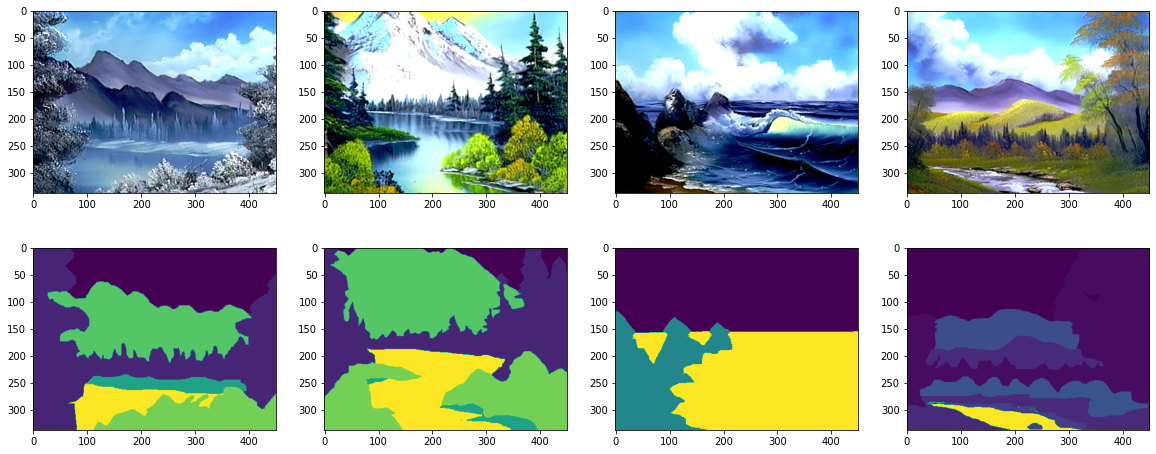

In [3]:
# show examples

names = os.listdir('segmented-bob-ross-images/train/images')
ims_paths = [os.path.join('segmented-bob-ross-images/train/images', n) for n in names]
segs_paths = [os.path.join('segmented-bob-ross-images/train/labels', n) for n in names]

ims_paths.sort()
segs_paths.sort()

fig, ax = plt.subplots(2, 4, figsize=(20, 8))
ax = ax.ravel()

for i in range(4):
  im, seg = ims_paths[i], segs_paths[i]
  ax[i].imshow(Image.open(im))
  ax[i+4].imshow(Image.open(seg))

In [4]:
# get the classes information

labels = pd.read_csv('segmented-bob-ross-images/labels.csv')
labels

Id                   class
0   3                     sky
1   5                    tree
2  10                   grass
3  14              earth;rock
4  17          mountain;mount
5  18  plant;flora;plant;life
6  22                   water
7  27                     sea
8  61                   river

This `IDs` are not representative for us, we need values between 0 and `n_classes`, to represent the indexes of the class we are predicting. We'll build a function to clean this data. To understand the clean_labels function, we need to take into account that the ID's described above are thresholds (i.e the classes representing a sky are 0,1,2,3). We need to constraint these value to 0 (as it is the first class in the csv).

Also, we have repetitive values for water, sea, and river, we'll remove the last two.

In [5]:
def clean_labels(seg):
  # constraint names in labels
  clean_seg = seg.copy()
  prev_id = -1
  for i, id in enumerate(labels['Id']):
    clean_seg[(seg > prev_id) & (seg <= id)] = i
    prev_id = id
  return clean_seg

labels = labels.head(-2)
labels.loc[6, 'Id'] = 61  # re-set the highest value
labels

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Id                   class
0   3                     sky
1   5                    tree
2  10                   grass
3  14              earth;rock
4  17          mountain;mount
5  18  plant;flora;plant;life
6  61                   water

In [6]:
# define the num classes
num_classes = len(labels)
num_classes

7

### Create the Dataset

We'll define different helper functions to convert our images and segmentation masks to torch tensors and numpy arrays, and then a class Dataset to load our data on the go.

We need to define different transformations to make for train and validation. The extra transformations made in the training allows us to avoid overfitting by applying image augmentation.

In [ ]:
# define functions to handle our data

input_size = 128
input_crop = 128

means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

def get_transforms(train=False):
  if train:
    return [
      T.Resize(input_size),
      T.CenterCrop(input_crop)
      #T.RandomCrop(input_crop),
      #T.RandomChoice([
      #  T.RandomHorizontalFlip(),
      #  T.RandomVerticalFlip(),
      #  T.RandomRotation(degrees=20)  
      #])
    ]
  else:
    return [
      T.Resize(input_size),
      T.CenterCrop(input_crop)
    ]

def to_im_tensor(im, transforms):
  preprocess = T.Compose(transforms + [T.ToTensor(), T.Normalize(means, stds)])
  tensor = preprocess(im)
  return tensor

def to_seg_tensor(im, transforms):
  preprocess = T.Compose(transforms)
  im = preprocess(im)
  seg = np.array(im)
  seg = clean_labels(seg)
  tensor = torch.from_numpy(seg)
  return tensor

def to_pil(tensor):
  transform = T.Compose([
    T.ToPILImage()
  ])
  return transform(tensor)

In [ ]:
class BobRossDataset(torch.utils.data.Dataset):
  def __init__(self, ims_paths, segs_paths, train=False):
    self.ims_paths = ims_paths
    self.segs_paths = segs_paths
    self.train = train

  def __len__(self):
    return len(self.ims_paths)

  def __getitem__(self, idx):
    im_path = self.ims_paths[idx]
    seg_path = self.segs_paths[idx]
    im, seg = Image.open(im_path), Image.open(seg_path)
    transforms = get_transforms(train=self.train)
    return to_im_tensor(im, transforms), to_seg_tensor(seg, transforms)

### Dataloader

Let's check at the size of the full dataset, split this dataset into train/test using sklearn, define a batch_size and create the dataloaders.

In [9]:
batch_size = 23

X, y = ims_paths, segs_paths

len(X), len(y)

(250, 250)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=46)

train_dataset = BobRossDataset(X_train, y_train, train=True)
val_dataset = BobRossDataset(X_val, y_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

len(train_dataset), len(val_dataset)

(167, 83)

### UNet Model

Using [the Vanilla UNet segmentation model](https://arxiv.org/pdf/1505.04597.pdf):

<img src='https://miro.medium.com/max/2824/1*f7YOaE4TWubwaFF7Z1fzNw.png' height=400/>

In [11]:
class DoubleConvBlock(nn.Sequential):
  """
  Two convolutions followed by ReLU activation.
  Uses Batch Normalization and Dropout
  to avoid overfitting.
  """

  def __init__(self, in_channels, out_channels, dropout=False):
    layers = [
      nn.Conv2d(in_channels, out_channels, 3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channels, out_channels, 3, padding=1),
      nn.ReLU(inplace=True)
    ]
    if dropout: layers.append(nn.Dropout())
    super(DoubleConvBlock, self).__init__(*layers)


class EncoderBlock(nn.Module):
  """
  Runs a DoubleConvBlock, saves the tensor to perform the skip connection
  and runs a max pool. Forward step returns a tuple with (x, skip).
  """
  def __init__(self, in_channels, out_channels, dropout=False):
    super(EncoderBlock, self).__init__()
    self.conv_block = DoubleConvBlock(in_channels, out_channels, dropout)
    self.max_pool = nn.MaxPool2d(2)

  def forward(self, x):
    x = self.conv_block(x)
    skip = x.clone()
    x = self.max_pool(x)
    return x, skip


class DecoderBlock(nn.Module):
  """
  Runs an upsample, performs the skip connection and then a DoubleConvBlock.
  """
  def __init__(self, in_channels, out_channels, dropout=False):
    super(DecoderBlock, self).__init__()
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    self.conv_block = DoubleConvBlock(in_channels, out_channels, dropout)
  
  def crop(self, skip, x):
    """ Crop the skip connection to fit the concat size """
    _, _, width, height = skip.size()
    target_size = x.size()[-1]
    diff = (width - target_size) // 2
    return skip[:, :, diff:(diff + target_size), diff:(diff + target_size)]

  def forward(self, x, skip):
    x = self.upsample(x)
    skip = self.crop(skip, x)
    x = torch.cat([x, skip], axis=1)
    x = self.conv_block(x)
    return x


class CenterBlock(DoubleConvBlock):
  """ Just a DoubleConvBlock, with a cooler name. """
  def __init__(self, *args):
    super(CenterBlock, self).__init__(*args)


class FinalBlock(nn.Conv2d):
  """ Conv2d, with a cooler name. """
  def __init__(self, in_channels, n_classes):
    super(FinalBlock, self).__init__(in_channels, n_classes, kernel_size=1)


class UNet(nn.Module):
  """
  Creates three encoder blocks, a center block, three decoder blocks
  and a last layer to compute the class channels.
  Params: in_channels, n_classes
  TODO: add n_blocks as parameter
  """
  def __init__(self, in_channels, n_classes):
    super(UNet, self).__init__()
    self.down_block_1 = EncoderBlock(in_channels, 64)
    self.down_block_2 = EncoderBlock(64, 128, dropout=True)
    self.down_block_3 = EncoderBlock(128, 256, dropout=True)
    self.center_block = CenterBlock(256, 512)
    self.up_block_1 = DecoderBlock(256 + 512, 256)
    self.up_block_2 = DecoderBlock(128 + 256, 128)
    self.up_block_3 = DecoderBlock(64 + 128, 64)
    self.final_block = FinalBlock(64, n_classes)

  def forward(self, x):
    x, skip_1 = self.down_block_1(x)
    x, skip_2 = self.down_block_2(x)
    x, skip_3 = self.down_block_3(x)
    x = self.center_block(x)
    x = self.up_block_1(x, skip_3)
    x = self.up_block_2(x, skip_2)
    x = self.up_block_3(x, skip_1)
    x = self.final_block(x)
    return x

UNet(in_channels=3, n_classes=num_classes)

UNet(
  (down_block_1): EncoderBlock(
    (conv_block): DoubleConvBlock(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
    )
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_block_2): EncoderBlock(
    (conv_block): DoubleConvBlock(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): Dropout(p=0.5, inplace=False)
    )
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (d

### Training algorithms

Let's define the metrics and algorithms we'll use during training.

First, we'll define the Mean Intersection Over Union or Jaccard Score and the accuracy.

In [ ]:
def mean_iou(pred, real, n_classes=num_classes):
  # convert to numpy
  pred = pred.detach().cpu().numpy()
  real = real.detach().cpu().numpy()

  # indexes for max predictions
  pred = np.argmax(pred, axis=1)

  # for each sample in the batch
  batch = zip(pred, real)
  ious = [iou(p.ravel(), r.ravel(), average='macro') for p,r in batch]

  return np.mean(ious)

def accuracy(pred, target):
  pred = torch.argmax(pred, axis=1)
  return (pred == target).float().mean()

### Hyper params

In [ ]:
lr = .001
epochs = 200

unet = UNet(in_channels=3, n_classes=num_classes)
optimizer = optim.Adam(unet.parameters(), lr=lr, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Epoch algorithm

In [ ]:
def epoch(e, mode, model, data_loader, criterion, optimizer, device, metrics):
  train = mode == 'train'
  model.train() if train else model.eval()
  model.to(device)

  # init step loss, accuracy and iou
  epoch_loss, epoch_acc, epoch_iou = 0., 0., 0.

  loop = tqdm(data_loader) if train else data_loader
  for x, y in loop:
    x, y = x.to(device).float(), y.to(device).long()

    # pass the tensor through the net
    out = model(x)

    # loss
    batch_loss = criterion(out, y.squeeze(1))
    epoch_loss += batch_loss.item() * y.size(0)

    # optimize
    if train:
      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    with torch.no_grad():
      # accuracy
      batch_acc = accuracy(out, y)
      epoch_acc += batch_acc * y.size(0)
      # mean_iou
      batch_iou = mean_iou(out, y)
      epoch_iou += batch_iou * y.size(0)

    # show partial results
    if train:
      loop.set_description(f'Train Epoch {e + 1}/{epochs}')
      loop.set_postfix(loss=batch_loss.item(),
                       acc=batch_acc.item(),
                       iou=batch_iou)
  
  epoch_loss /= len(data_loader.dataset)
  epoch_acc /= len(data_loader.dataset)
  epoch_iou /= len(data_loader.dataset)

  print(f'{mode.capitalize()} Epoch {e + 1}/{epochs} '
        f'loss: {epoch_loss} '
        f'acc: {epoch_acc} '
        f'iou: {epoch_iou} ')

  metrics.add(mode, 'loss', epoch_loss)
  metrics.add(mode, 'acc', epoch_acc)
  metrics.add(mode, 'iou', epoch_iou)

### Metrics

Let's define an object to manage our metrics.

In [ ]:
class Metrics:
  def __init__(self, names):
    self.metrics = {'train': {}, 'eval': {}}
    self.names = names
    for m in names:
      self.metrics['train'][m] = []
      self.metrics['eval'][m] = []
  
  def add(self, mode, name, value):
    assert name in self.names, 'Wrong metric name'
    self.metrics[mode][name].append(value)
  
  def plot(self):
    f, ax = plt.subplots(1, len(self.names), figsize=(15, 5))
    for i, name in enumerate(self.names):
      ax[i].set_title(name)
      ax[i].plot(self.metrics['train'][name], label=f'train {name}')
      ax[i].plot(self.metrics['eval'][name], label=f'eval {name}')
      ax[i].legend()
    plt.show()

### Train, finally ...

In [16]:
metrics = Metrics(['loss', 'acc', 'iou'])

for e in range(epochs):
  epoch(e, 'train', unet, train_loader, criterion, optimizer, device, metrics)
  epoch(e, 'eval', unet, val_loader, criterion, optimizer, device, metrics)


Train Epoch 1/200 loss: 1.7829943267171255 acc: 0.32559478282928467 iou: 0.08360491347450394 
Eval Epoch 1/200 loss: 1.693062749253698 acc: 0.39283180236816406 iou: 0.10233637506285215 



Train Epoch 2/200 loss: 1.5353580020858857 acc: 0.42994189262390137 iou: 0.1407729262689196 
Eval Epoch 2/200 loss: 2.0274563826710343 acc: 0.395570307970047 iou: 0.13110097320173236 



Train Epoch 3/200 loss: 1.4021791819326892 acc: 0.4710225760936737 iou: 0.17841778319255028 
Eval Epoch 3/200 loss: 1.6132271548351609 acc: 0.4703155755996704 iou: 0.17406084638144853 



Train Epoch 4/200 loss: 1.3534698629093742 acc: 0.48628684878349304 iou: 0.20460779500636883 
Eval Epoch 4/200 loss: 1.4684471006853035 acc: 0.43698227405548096 iou: 0.17765151228856188 



Train Epoch 5/200 loss: 1.3195626285975566 acc: 0.5021954774856567 iou: 0.21925635058675916 
Eval Epoch 5/200 loss: 1.3471937165202865 acc: 0.4820210933685303 iou: 0.2065565995288531 



Train Epoch 6/200 loss: 1.2733987405628502 acc: 0.5187041759490967 iou: 0.21797171142534427 
Eval Epoch 6/200 loss: 1.2462339832122067 acc: 0.5391933917999268 iou: 0.23358570644540716 



Train Epoch 7/200 loss: 1.2189052212024163 acc: 0.5451920032501221 iou: 0.24085133826888025 
Eval Epoch 7/200 loss: 1.2243744091815258 acc: 0.560183584690094 iou: 0.2409324011709169 



Train Epoch 8/200 loss: 1.1869020854641577 acc: 0.5612548589706421 iou: 0.2586920211080455 
Eval Epoch 8/200 loss: 1.2641331086675804 acc: 0.5332207679748535 iou: 0.24091007997949598 



Train Epoch 9/200 loss: 1.152847118720323 acc: 0.578284740447998 iou: 0.26425190370570006 
Eval Epoch 9/200 loss: 1.1860765505986042 acc: 0.5746694803237915 iou: 0.2662175751622826 



Train Epoch 10/200 loss: 1.110212777189152 acc: 0.5976489782333374 iou: 0.28197647731065206 
Eval Epoch 10/200 loss: 1.3154476177261536 acc: 0.512270987033844 iou: 0.21122551823693456 



Train Epoch 11/200 loss: 1.0743821652349597 acc: 0.6056569814682007 iou: 0.2849733969184448 
Eval Epoch 11/200 loss: 1.2828726280166443 acc: 0.5592077374458313 iou: 0.2307126067571396 



Train Epoch 12/200 loss: 1.0482886504984188 acc: 0.6180610060691833 iou: 0.2999350189156412 
Eval Epoch 12/200 loss: 1.186531783586525 acc: 0.5705139636993408 iou: 0.29090757256469063 



Train Epoch 13/200 loss: 1.00850959238178 acc: 0.635405957698822 iou: 0.30335059119743196 
Eval Epoch 13/200 loss: 1.3450812259352352 acc: 0.5089457035064697 iou: 0.22504259063132148 



Train Epoch 14/200 loss: 1.014691042329023 acc: 0.6370831727981567 iou: 0.30702304186908136 
Eval Epoch 14/200 loss: 1.3136372422597495 acc: 0.5555294752120972 iou: 0.24318931614595926 



Train Epoch 15/200 loss: 0.9719088791373247 acc: 0.6533872485160828 iou: 0.31974092064570336 
Eval Epoch 15/200 loss: 1.3369190032223621 acc: 0.5463219881057739 iou: 0.24557482286178553 



Train Epoch 16/200 loss: 0.9368933838998487 acc: 0.6684073805809021 iou: 0.32797582636249706 
Eval Epoch 16/200 loss: 1.156515296683254 acc: 0.5905290842056274 iou: 0.2723454682752078 



Train Epoch 17/200 loss: 0.9124843985020757 acc: 0.6759676933288574 iou: 0.3341780295984831 
Eval Epoch 17/200 loss: 1.1418481749224376 acc: 0.5944986343383789 iou: 0.27454838263760356 



Train Epoch 18/200 loss: 0.8641447085820272 acc: 0.6963552236557007 iou: 0.3419169546411737 
Eval Epoch 18/200 loss: 1.1908802354192158 acc: 0.5874251127243042 iou: 0.27105386836836276 



Train Epoch 19/200 loss: 0.8599506159742435 acc: 0.7033699154853821 iou: 0.35246025895408 
Eval Epoch 19/200 loss: 1.1839806344135697 acc: 0.600004255771637 iou: 0.2922280876605095 



Train Epoch 20/200 loss: 0.823336229709808 acc: 0.7103531360626221 iou: 0.3570205812909864 
Eval Epoch 20/200 loss: 1.2811666425452175 acc: 0.5562023520469666 iou: 0.2508464523100898 



Train Epoch 21/200 loss: 0.8438500676326409 acc: 0.7075458765029907 iou: 0.3556970081631328 
Eval Epoch 21/200 loss: 1.0894465403384472 acc: 0.6091507077217102 iou: 0.30360642135302107 



Train Epoch 22/200 loss: 0.8093253959438758 acc: 0.7164398431777954 iou: 0.3597342823095394 
Eval Epoch 22/200 loss: 1.085897776017706 acc: 0.6198318600654602 iou: 0.31041627904912356 



Train Epoch 23/200 loss: 0.7915456712602855 acc: 0.7215280532836914 iou: 0.3639747206033899 
Eval Epoch 23/200 loss: 1.0592901519982212 acc: 0.630618155002594 iou: 0.3078634646496237 



Train Epoch 24/200 loss: 0.756981619460854 acc: 0.7377136945724487 iou: 0.3706839320977174 
Eval Epoch 24/200 loss: 1.218289938317724 acc: 0.5764873027801514 iou: 0.27456983603493246 



Train Epoch 25/200 loss: 0.7378757531771403 acc: 0.7443058490753174 iou: 0.3819738819470029 
Eval Epoch 25/200 loss: 1.2435231567865395 acc: 0.5811767578125 iou: 0.27732174702798146 



Train Epoch 26/200 loss: 0.7318861944946701 acc: 0.7465184926986694 iou: 0.3841482848931055 
Eval Epoch 26/200 loss: 1.2931455072150173 acc: 0.5511540770530701 iou: 0.25655593729980253 



Train Epoch 27/200 loss: 0.7054784876143861 acc: 0.7554975748062134 iou: 0.3877589166766562 
Eval Epoch 27/200 loss: 1.0846854060529225 acc: 0.6417824625968933 iou: 0.3246751954914642 



Train Epoch 28/200 loss: 0.7232954320079552 acc: 0.7483663558959961 iou: 0.383405779329794 
Eval Epoch 28/200 loss: 1.1181172620819275 acc: 0.6139438152313232 iou: 0.29393636540341556 



Train Epoch 29/200 loss: 0.6984157665760932 acc: 0.754152238368988 iou: 0.39010991824775676 
Eval Epoch 29/200 loss: 1.0859384737819073 acc: 0.6361443996429443 iou: 0.3072330281934068 



Train Epoch 30/200 loss: 0.6972031011552868 acc: 0.7595434188842773 iou: 0.3933392609816476 
Eval Epoch 30/200 loss: 0.9651080147329584 acc: 0.6667546629905701 iou: 0.33433762027399194 



Train Epoch 31/200 loss: 0.6783400045897432 acc: 0.7612093091011047 iou: 0.398046380336132 
Eval Epoch 31/200 loss: 1.1110236142055099 acc: 0.642308235168457 iou: 0.32748746903058784 



Train Epoch 32/200 loss: 0.6601412364108834 acc: 0.7711350321769714 iou: 0.4045898800724289 
Eval Epoch 32/200 loss: 1.0314938785081886 acc: 0.6625439524650574 iou: 0.34284109771768223 



Train Epoch 33/200 loss: 0.6317845600807738 acc: 0.7814798951148987 iou: 0.41068550328455783 
Eval Epoch 33/200 loss: 1.083858433976231 acc: 0.6380071043968201 iou: 0.31817426902042345 



Train Epoch 34/200 loss: 0.6401317697799135 acc: 0.7772308588027954 iou: 0.4087533270578991 
Eval Epoch 34/200 loss: 1.0998977824866054 acc: 0.6458306312561035 iou: 0.3283128740168523 



Train Epoch 35/200 loss: 0.6244909360023316 acc: 0.7848569750785828 iou: 0.41610384039318704 
Eval Epoch 35/200 loss: 1.108309191393565 acc: 0.6424354314804077 iou: 0.32731554465688545 



Train Epoch 36/200 loss: 0.5912547511254956 acc: 0.797024130821228 iou: 0.42524252020215825 
Eval Epoch 36/200 loss: 1.3130410521863454 acc: 0.5749658346176147 iou: 0.27048172381994323 



Train Epoch 37/200 loss: 0.5679175723455623 acc: 0.8057448863983154 iou: 0.43420757813927285 
Eval Epoch 37/200 loss: 1.2711817672453731 acc: 0.6082895994186401 iou: 0.29104463168891376 



Train Epoch 38/200 loss: 0.5631889297576722 acc: 0.8046337962150574 iou: 0.43365949949917804 
Eval Epoch 38/200 loss: 1.2392928930650275 acc: 0.6026839017868042 iou: 0.28447924505294236 



Train Epoch 39/200 loss: 0.5444014334750032 acc: 0.8137784600257874 iou: 0.4441704770881863 
Eval Epoch 39/200 loss: 1.3086648906569882 acc: 0.6125458478927612 iou: 0.28458110690219884 



Train Epoch 40/200 loss: 0.5680224394013068 acc: 0.8057869076728821 iou: 0.4336505154780454 
Eval Epoch 40/200 loss: 1.2102652026946286 acc: 0.6184736490249634 iou: 0.30532377010128514 



Train Epoch 41/200 loss: 0.5682424173026741 acc: 0.8044280409812927 iou: 0.4304778198093041 
Eval Epoch 41/200 loss: 1.0568641589348575 acc: 0.675819456577301 iou: 0.3326519984527068 



Train Epoch 42/200 loss: 0.5570710438811136 acc: 0.8098214268684387 iou: 0.43985384729947236 
Eval Epoch 42/200 loss: 1.0778377530086471 acc: 0.6679201722145081 iou: 0.35431176313897494 



Train Epoch 43/200 loss: 0.5234189634908459 acc: 0.819760262966156 iou: 0.4517152742655719 
Eval Epoch 43/200 loss: 1.1294023602841847 acc: 0.6384387612342834 iou: 0.3142656198652433 



Train Epoch 44/200 loss: 0.5062106114304709 acc: 0.8276214003562927 iou: 0.4579606676611614 
Eval Epoch 44/200 loss: 1.2038893512932651 acc: 0.6407963037490845 iou: 0.3117459817394358 



Train Epoch 45/200 loss: 0.4951162215121492 acc: 0.8300865888595581 iou: 0.45888572529030225 
Eval Epoch 45/200 loss: 1.2409640694239052 acc: 0.6193501949310303 iou: 0.3134576010263691 



Train Epoch 46/200 loss: 0.482930336883682 acc: 0.8363457918167114 iou: 0.4657693937974571 
Eval Epoch 46/200 loss: 1.1818741401994084 acc: 0.643589973449707 iou: 0.308954473940674 



Train Epoch 47/200 loss: 0.4634517754266362 acc: 0.8418557643890381 iou: 0.4737992766120179 
Eval Epoch 47/200 loss: 1.3276672463819206 acc: 0.6100316643714905 iou: 0.2927947101140507 



Train Epoch 48/200 loss: 0.4507294895049341 acc: 0.846559464931488 iou: 0.47383771466309355 
Eval Epoch 48/200 loss: 1.2571730771696712 acc: 0.6440436840057373 iou: 0.30086618280941607 



Train Epoch 49/200 loss: 0.43055708251313535 acc: 0.855598509311676 iou: 0.48538713518861176 
Eval Epoch 49/200 loss: 1.3479926729776772 acc: 0.6172581315040588 iou: 0.29393848174941134 



Train Epoch 50/200 loss: 0.43982620974500736 acc: 0.8519700169563293 iou: 0.4794065078339429 
Eval Epoch 50/200 loss: 1.1167779909559044 acc: 0.6712256669998169 iou: 0.3252396956201332 



Train Epoch 51/200 loss: 0.43149474655796666 acc: 0.8540291786193848 iou: 0.47779530183147834 
Eval Epoch 51/200 loss: 1.1747285084552075 acc: 0.6581699848175049 iou: 0.3253488674489105 



Train Epoch 52/200 loss: 0.4194939491634597 acc: 0.859926164150238 iou: 0.48834661561645626 
Eval Epoch 52/200 loss: 1.2485185861587524 acc: 0.6469954252243042 iou: 0.3337639047774369 



Train Epoch 53/200 loss: 0.4390384526309853 acc: 0.8516315817832947 iou: 0.4826280478973891 
Eval Epoch 53/200 loss: 1.2221501074641583 acc: 0.6380857825279236 iou: 0.32155185231358746 



Train Epoch 54/200 loss: 0.4178402875354904 acc: 0.8608015179634094 iou: 0.4880620831042179 
Eval Epoch 54/200 loss: 1.19138413595866 acc: 0.6587399244308472 iou: 0.32472982887365254 



Train Epoch 55/200 loss: 0.4249438570288127 acc: 0.8545287847518921 iou: 0.481700337126628 
Eval Epoch 55/200 loss: 1.1411505463611649 acc: 0.6759245991706848 iou: 0.3372209640260609 



Train Epoch 56/200 loss: 0.418205016922808 acc: 0.8575541973114014 iou: 0.49013069857965125 
Eval Epoch 56/200 loss: 1.2226489021117428 acc: 0.6543211340904236 iou: 0.31726177362734065 



Train Epoch 57/200 loss: 0.4115778941237284 acc: 0.8602814078330994 iou: 0.4926875480538542 
Eval Epoch 57/200 loss: 1.2688777647822735 acc: 0.6356965899467468 iou: 0.31280336790477575 



Train Epoch 58/200 loss: 0.4094852467853866 acc: 0.8633835911750793 iou: 0.49630919683601565 
Eval Epoch 58/200 loss: 1.3947335783257542 acc: 0.586708128452301 iou: 0.30185659617993066 



Train Epoch 59/200 loss: 0.39097834097411105 acc: 0.8682985901832581 iou: 0.5017074633198068 
Eval Epoch 59/200 loss: 1.2207361028855106 acc: 0.652957022190094 iou: 0.3321801071580121 



Train Epoch 60/200 loss: 0.38997133763250474 acc: 0.8696413636207581 iou: 0.5048738867617021 
Eval Epoch 60/200 loss: 1.0972292710499592 acc: 0.6820141673088074 iou: 0.34466117058110074 



Train Epoch 61/200 loss: 0.390436413759243 acc: 0.869642436504364 iou: 0.5059712458027462 
Eval Epoch 61/200 loss: 1.217720278056271 acc: 0.6558109521865845 iou: 0.31298911653830686 



Train Epoch 62/200 loss: 0.3967739209800423 acc: 0.8663684725761414 iou: 0.4946752879882472 
Eval Epoch 62/200 loss: 1.1529057471148938 acc: 0.6708844304084778 iou: 0.33208648326145096 



Train Epoch 63/200 loss: 0.3795052565143494 acc: 0.8724749088287354 iou: 0.5041160464540206 
Eval Epoch 63/200 loss: 1.097390376659761 acc: 0.6910319328308105 iou: 0.35878534977147203 



Train Epoch 64/200 loss: 0.36896771067630746 acc: 0.8780634999275208 iou: 0.5183864460573342 
Eval Epoch 64/200 loss: 1.1899371807833752 acc: 0.6684144139289856 iou: 0.33676522152893623 



Train Epoch 65/200 loss: 0.338949081069695 acc: 0.8862966299057007 iou: 0.5203069315513031 
Eval Epoch 65/200 loss: 1.2257614882595569 acc: 0.6514730453491211 iou: 0.3293376925572297 



Train Epoch 66/200 loss: 0.3390661797480669 acc: 0.886648952960968 iou: 0.5219974033524168 
Eval Epoch 66/200 loss: 1.286606547344162 acc: 0.6550748944282532 iou: 0.315753729741363 



Train Epoch 67/200 loss: 0.3161579431174044 acc: 0.8950751423835754 iou: 0.5356581327144009 
Eval Epoch 67/200 loss: 1.2672381530325096 acc: 0.6680547595024109 iou: 0.3244594258592011 



Train Epoch 68/200 loss: 0.31494580789240534 acc: 0.8950403928756714 iou: 0.5451096805088036 
Eval Epoch 68/200 loss: 1.1595240931913078 acc: 0.6729280352592468 iou: 0.3501692689533141 



Train Epoch 69/200 loss: 0.317077689185114 acc: 0.8947246074676514 iou: 0.5405311154240275 
Eval Epoch 69/200 loss: 1.1443943216140011 acc: 0.6854336261749268 iou: 0.34871224071707735 



Train Epoch 70/200 loss: 0.3278113050375156 acc: 0.8897351026535034 iou: 0.5261834765588752 
Eval Epoch 70/200 loss: 1.2191113348466804 acc: 0.6717433333396912 iou: 0.3407274723513813 



Train Epoch 71/200 loss: 0.319548047766714 acc: 0.893303632736206 iou: 0.5333964161679503 
Eval Epoch 71/200 loss: 1.3593924490802258 acc: 0.6397727131843567 iou: 0.3121308557346793 



Train Epoch 72/200 loss: 0.30832562689295784 acc: 0.8977910280227661 iou: 0.5418869924350791 
Eval Epoch 72/200 loss: 1.2460698722356773 acc: 0.6638918519020081 iou: 0.3254764160630905 



Train Epoch 73/200 loss: 0.2835440431347864 acc: 0.906588077545166 iou: 0.5562708952521472 
Eval Epoch 73/200 loss: 1.214161538216005 acc: 0.6744318604469299 iou: 0.3334467877354912 



Train Epoch 74/200 loss: 0.2687998818244763 acc: 0.9122877717018127 iou: 0.5575337648747287 
Eval Epoch 74/200 loss: 1.1768698318895088 acc: 0.6701917052268982 iou: 0.3567027110074635 



Train Epoch 75/200 loss: 0.26019667874196334 acc: 0.9144996404647827 iou: 0.5686331930657439 
Eval Epoch 75/200 loss: 1.3061315625546925 acc: 0.6525489091873169 iou: 0.323753516608981 



Train Epoch 76/200 loss: 0.2526066236331791 acc: 0.9174776077270508 iou: 0.5754338913715168 
Eval Epoch 76/200 loss: 1.2857679889862796 acc: 0.6758547425270081 iou: 0.32331176031458947 



Train Epoch 77/200 loss: 0.24773206414576776 acc: 0.9182834625244141 iou: 0.5722426094636216 
Eval Epoch 77/200 loss: 1.430595785738474 acc: 0.6649919748306274 iou: 0.3288512270741577 



Train Epoch 78/200 loss: 0.24423149968692642 acc: 0.9188240170478821 iou: 0.580285403341495 
Eval Epoch 78/200 loss: 1.2993553058210625 acc: 0.671241819858551 iou: 0.32765832904936903 



Train Epoch 79/200 loss: 0.24678383767604828 acc: 0.9174531102180481 iou: 0.574329202026425 
Eval Epoch 79/200 loss: 1.2243280396404037 acc: 0.6862013339996338 iou: 0.34645687968302447 



Train Epoch 80/200 loss: 0.24062052806337436 acc: 0.9200356006622314 iou: 0.5751996606109896 
Eval Epoch 80/200 loss: 1.1703272167458592 acc: 0.6968626379966736 iou: 0.3620875518662908 



Train Epoch 81/200 loss: 0.2487091811117298 acc: 0.9164542555809021 iou: 0.5711657622948408 
Eval Epoch 81/200 loss: 1.4173427245703087 acc: 0.6567044258117676 iou: 0.31966818397155494 



Train Epoch 82/200 loss: 0.24258147064083352 acc: 0.9192113876342773 iou: 0.5768527625145695 
Eval Epoch 82/200 loss: 1.3107072186757283 acc: 0.6670789122581482 iou: 0.33562482334164967 



Train Epoch 83/200 loss: 0.2432125219684875 acc: 0.919304609298706 iou: 0.570412272019001 
Eval Epoch 83/200 loss: 1.3816209930971444 acc: 0.6755966544151306 iou: 0.3288230873892676 



Train Epoch 84/200 loss: 0.24698743277681087 acc: 0.9171446561813354 iou: 0.5761205938162187 
Eval Epoch 84/200 loss: 1.3316647417574043 acc: 0.6742671132087708 iou: 0.3408593927071319 



Train Epoch 85/200 loss: 0.24474335600159125 acc: 0.91901695728302 iou: 0.5767099959292701 
Eval Epoch 85/200 loss: 1.2402597924312913 acc: 0.6836437582969666 iou: 0.3460256570074259 



Train Epoch 86/200 loss: 0.23211708602434147 acc: 0.9231633543968201 iou: 0.5839567980335035 
Eval Epoch 86/200 loss: 1.473003611507186 acc: 0.650576651096344 iou: 0.31551936068340863 



Train Epoch 87/200 loss: 0.232980582617714 acc: 0.9218955039978027 iou: 0.5839934661319187 
Eval Epoch 87/200 loss: 1.3031768138150135 acc: 0.6651831865310669 iou: 0.33135122714645643 



Train Epoch 88/200 loss: 0.23547605706189206 acc: 0.920989453792572 iou: 0.5822545422542974 
Eval Epoch 88/200 loss: 1.3180704360984894 acc: 0.6723058819770813 iou: 0.3313751468359028 



Train Epoch 89/200 loss: 0.24469025165377978 acc: 0.9182841777801514 iou: 0.5772857071570936 
Eval Epoch 89/200 loss: 1.2933757592396564 acc: 0.6692386865615845 iou: 0.33682727374827326 



Train Epoch 90/200 loss: 0.24742418679291617 acc: 0.9173895120620728 iou: 0.5743091614885842 
Eval Epoch 90/200 loss: 1.3898743807551373 acc: 0.6572265625 iou: 0.32978265930812917 



Train Epoch 91/200 loss: 0.2626091320357637 acc: 0.9149327278137207 iou: 0.5762724504637142 
Eval Epoch 91/200 loss: 1.437247748834541 acc: 0.6662737131118774 iou: 0.3363788687553054 



Train Epoch 92/200 loss: 0.32654627140410647 acc: 0.8916410803794861 iou: 0.5383582251148091 
Eval Epoch 92/200 loss: 1.1168000489832408 acc: 0.7128589749336243 iou: 0.369557222412896 



Train Epoch 93/200 loss: 0.3577743552759022 acc: 0.8820472359657288 iou: 0.5239860594241015 
Eval Epoch 93/200 loss: 1.3719139271471874 acc: 0.6369775533676147 iou: 0.3334130438555285 



Train Epoch 94/200 loss: 0.4120331365548208 acc: 0.864536702632904 iou: 0.5035370620321581 
Eval Epoch 94/200 loss: 1.1084412609238223 acc: 0.6872279047966003 iou: 0.35706289772959315 



Train Epoch 95/200 loss: 0.3521250955715865 acc: 0.8844491243362427 iou: 0.527382547901706 
Eval Epoch 95/200 loss: 1.0634976316647358 acc: 0.6908164620399475 iou: 0.3543072861059045 



Train Epoch 96/200 loss: 0.36399285093752926 acc: 0.8798152208328247 iou: 0.5172358849804122 
Eval Epoch 96/200 loss: 1.2245553157415734 acc: 0.6657493710517883 iou: 0.32792712912147637 



Train Epoch 97/200 loss: 0.32895537675497777 acc: 0.8913190960884094 iou: 0.5354930036661127 
Eval Epoch 97/200 loss: 1.3193455087133201 acc: 0.6457718014717102 iou: 0.305722241138403 



Train Epoch 98/200 loss: 0.30441889728971583 acc: 0.898675799369812 iou: 0.5455385724873671 
Eval Epoch 98/200 loss: 1.3477967259395554 acc: 0.6597407460212708 iou: 0.32011057091282 



Train Epoch 99/200 loss: 0.28512076524917235 acc: 0.9037256836891174 iou: 0.5554280478156147 
Eval Epoch 99/200 loss: 1.6429927708154701 acc: 0.6051598787307739 iou: 0.2791176990236395 



Train Epoch 100/200 loss: 0.26050302047215534 acc: 0.9130764603614807 iou: 0.5657937559964442 
Eval Epoch 100/200 loss: 1.2220917983227466 acc: 0.662995457649231 iou: 0.3374305755348686 



Train Epoch 101/200 loss: 0.24229257263823184 acc: 0.9203100204467773 iou: 0.578757271912708 
Eval Epoch 101/200 loss: 1.2248061679932007 acc: 0.6813280582427979 iou: 0.34520709592278975 



Train Epoch 102/200 loss: 0.21929158671887336 acc: 0.9272797703742981 iou: 0.5961039012055971 
Eval Epoch 102/200 loss: 1.238630955477795 acc: 0.6840459704399109 iou: 0.3376540926197428 



Train Epoch 103/200 loss: 0.20694961215921504 acc: 0.9311344623565674 iou: 0.5972448826602813 
Eval Epoch 103/200 loss: 1.3301040049058845 acc: 0.6677458882331848 iou: 0.33355852305615125 



Train Epoch 104/200 loss: 0.19263190477194186 acc: 0.9351879954338074 iou: 0.6066556546824895 
Eval Epoch 104/200 loss: 1.402871516813715 acc: 0.6734045147895813 iou: 0.33428798459278275 



Train Epoch 105/200 loss: 0.1827582282398989 acc: 0.9381505846977234 iou: 0.6216609069793646 
Eval Epoch 105/200 loss: 1.3214633608438882 acc: 0.6848343014717102 iou: 0.34334093194011156 



Train Epoch 106/200 loss: 0.17584726785471338 acc: 0.9402217864990234 iou: 0.6230414116879885 
Eval Epoch 106/200 loss: 1.4141872216420002 acc: 0.6727839112281799 iou: 0.3349520441330436 



Train Epoch 107/200 loss: 0.17185459317204482 acc: 0.9415265321731567 iou: 0.6278624442236853 
Eval Epoch 107/200 loss: 1.3917959095483803 acc: 0.6898185610771179 iou: 0.3474779649168933 



Train Epoch 108/200 loss: 0.1704827103607669 acc: 0.9419000744819641 iou: 0.625640244991647 
Eval Epoch 108/200 loss: 1.465380032378507 acc: 0.6693924069404602 iou: 0.33562090431074937 



Train Epoch 109/200 loss: 0.16723375084871303 acc: 0.9425089359283447 iou: 0.6311175348692606 
Eval Epoch 109/200 loss: 1.3880494660641773 acc: 0.6887544989585876 iou: 0.3487209190706224 



Train Epoch 110/200 loss: 0.16669154113638188 acc: 0.943036675453186 iou: 0.6323908955323835 
Eval Epoch 110/200 loss: 1.3965728670717723 acc: 0.6861976385116577 iou: 0.34360916641304884 



Train Epoch 111/200 loss: 0.16801088646857323 acc: 0.942279040813446 iou: 0.6306781221539566 
Eval Epoch 111/200 loss: 1.4277112929217786 acc: 0.6911098957061768 iou: 0.34808129654899905 



Train Epoch 112/200 loss: 0.16719398054177176 acc: 0.9425444006919861 iou: 0.6312318429355511 
Eval Epoch 112/200 loss: 1.5585529804229736 acc: 0.6590414047241211 iou: 0.32797221984771047 



Train Epoch 113/200 loss: 0.1688058827808517 acc: 0.9417238831520081 iou: 0.6269923184290704 
Eval Epoch 113/200 loss: 1.410022307591266 acc: 0.7012534737586975 iou: 0.3590513524474166 



Train Epoch 114/200 loss: 0.17051555724914916 acc: 0.9414699077606201 iou: 0.6268026062131996 
Eval Epoch 114/200 loss: 1.3631472860474185 acc: 0.6947242021560669 iou: 0.3513141474823036 



Train Epoch 115/200 loss: 0.1695243274558804 acc: 0.9417260885238647 iou: 0.6284157333292387 
Eval Epoch 115/200 loss: 1.4261221842593457 acc: 0.6916592121124268 iou: 0.34901311730129336 



Train Epoch 116/200 loss: 0.16733511622080546 acc: 0.9422724843025208 iou: 0.6305489674222888 
Eval Epoch 116/200 loss: 1.4091834418744926 acc: 0.6915334463119507 iou: 0.35594590390370145 



Train Epoch 117/200 loss: 0.16635018649572383 acc: 0.9429405927658081 iou: 0.6333735463193988 
Eval Epoch 117/200 loss: 1.4357315589146442 acc: 0.6946035623550415 iou: 0.34947147750257496 



Train Epoch 118/200 loss: 0.16712871399111376 acc: 0.942348837852478 iou: 0.6313225365218519 
Eval Epoch 118/200 loss: 1.3919457771691932 acc: 0.6832172274589539 iou: 0.3495490671028801 



Train Epoch 119/200 loss: 0.1658515381420444 acc: 0.942840039730072 iou: 0.6321828101564569 
Eval Epoch 119/200 loss: 1.364686168820025 acc: 0.6986606121063232 iou: 0.35633041778756586 



Train Epoch 120/200 loss: 0.163524342957371 acc: 0.94358891248703 iou: 0.6328597587757119 
Eval Epoch 120/200 loss: 1.4248096296586186 acc: 0.7011225819587708 iou: 0.3595332962196424 



Train Epoch 121/200 loss: 0.16502533969051109 acc: 0.9427230954170227 iou: 0.6293036681134592 
Eval Epoch 121/200 loss: 1.4536040217043407 acc: 0.6818913817405701 iou: 0.3393398745646441 



Train Epoch 122/200 loss: 0.16471191955183795 acc: 0.9428912401199341 iou: 0.6312169401390816 
Eval Epoch 122/200 loss: 1.487353669591697 acc: 0.6823678612709045 iou: 0.34530690483963816 



Train Epoch 123/200 loss: 0.16500975673427126 acc: 0.9430593252182007 iou: 0.6312630463934731 
Eval Epoch 123/200 loss: 1.403149122215179 acc: 0.6994025707244873 iou: 0.36398030596059894 



Train Epoch 124/200 loss: 0.17317893405160503 acc: 0.9404172897338867 iou: 0.6280261435671138 
Eval Epoch 124/200 loss: 1.310446798083294 acc: 0.706388533115387 iou: 0.36214135106903295 



Train Epoch 125/200 loss: 0.17436231253389828 acc: 0.9401271343231201 iou: 0.6225091553678517 
Eval Epoch 125/200 loss: 1.3861800532743156 acc: 0.685215175151825 iou: 0.3649464991681475 



Train Epoch 126/200 loss: 0.17499395321586175 acc: 0.9400989413261414 iou: 0.6250854708282217 
Eval Epoch 126/200 loss: 1.520895193858319 acc: 0.6848570704460144 iou: 0.3400218565039989 



Train Epoch 127/200 loss: 0.17369162402824015 acc: 0.93980473279953 iou: 0.6226397602788517 
Eval Epoch 127/200 loss: 1.549135670604476 acc: 0.6817215085029602 iou: 0.34653703855247764 



Train Epoch 128/200 loss: 0.16573758280562784 acc: 0.942676305770874 iou: 0.6295453342292558 
Eval Epoch 128/200 loss: 1.6444760000849346 acc: 0.6732581853866577 iou: 0.3285356286293653 



Train Epoch 129/200 loss: 0.16553771540433346 acc: 0.94266277551651 iou: 0.6328876048031823 
Eval Epoch 129/200 loss: 1.4317788259092583 acc: 0.6923232078552246 iou: 0.35553126719917805 



Train Epoch 130/200 loss: 0.1648420830686649 acc: 0.9431115984916687 iou: 0.635371038255925 
Eval Epoch 130/200 loss: 1.2804703066147953 acc: 0.7099565267562866 iou: 0.3669482039281706 



Train Epoch 131/200 loss: 0.1658731416135491 acc: 0.942539632320404 iou: 0.6294056408667357 
Eval Epoch 131/200 loss: 1.277826204357377 acc: 0.7077246904373169 iou: 0.3660252831957704 



Train Epoch 132/200 loss: 0.16999570275852066 acc: 0.9413149356842041 iou: 0.6281651873034221 
Eval Epoch 132/200 loss: 1.593701993126467 acc: 0.682292103767395 iou: 0.3391844730992103 



Train Epoch 133/200 loss: 0.17113607193895441 acc: 0.940883994102478 iou: 0.6295150861509038 
Eval Epoch 133/200 loss: 1.4807264632489308 acc: 0.6788462400436401 iou: 0.3334664185748307 



Train Epoch 134/200 loss: 0.17350801557837847 acc: 0.9399513006210327 iou: 0.6253908484148953 
Eval Epoch 134/200 loss: 1.3730823663343865 acc: 0.694707989692688 iou: 0.35549913409742256 



Train Epoch 135/200 loss: 0.17655661496930494 acc: 0.9395174980163574 iou: 0.6181844818854123 
Eval Epoch 135/200 loss: 1.5328303604240876 acc: 0.668488621711731 iou: 0.3300587970275372 



Train Epoch 136/200 loss: 0.18456340737328558 acc: 0.9369667768478394 iou: 0.6180921394491079 
Eval Epoch 136/200 loss: 1.3881084760987614 acc: 0.6820803284645081 iou: 0.3474795548878313 



Train Epoch 137/200 loss: 0.2021894943036005 acc: 0.9315606355667114 iou: 0.6027042771795753 
Eval Epoch 137/200 loss: 1.3832033312464336 acc: 0.7038912177085876 iou: 0.34565899987150095 



Train Epoch 138/200 loss: 0.2613376437903878 acc: 0.9171654582023621 iou: 0.5762506744074133 
Eval Epoch 138/200 loss: 1.4291109435529594 acc: 0.681608259677887 iou: 0.3438716136743604 



Train Epoch 139/200 loss: 0.28974534178565364 acc: 0.9041869044303894 iou: 0.5550344300634472 
Eval Epoch 139/200 loss: 1.3322259704750705 acc: 0.685636579990387 iou: 0.34957123073155205 



Train Epoch 140/200 loss: 0.31864322427504077 acc: 0.8945842981338501 iou: 0.5464157918546946 
Eval Epoch 140/200 loss: 1.3358568297811302 acc: 0.684968113899231 iou: 0.34436677656177056 



Train Epoch 141/200 loss: 0.32364971320072333 acc: 0.8913772106170654 iou: 0.5345671816430838 
Eval Epoch 141/200 loss: 1.282222041164536 acc: 0.6692747473716736 iou: 0.3269168997247439 



Train Epoch 142/200 loss: 0.2927138423491381 acc: 0.903100311756134 iou: 0.54531494840966 
Eval Epoch 142/200 loss: 1.2788194346140667 acc: 0.6559396386146545 iou: 0.333746291361437 



Train Epoch 143/200 loss: 0.26814754432189963 acc: 0.9097067713737488 iou: 0.5605104849769048 
Eval Epoch 143/200 loss: 1.2326465414231083 acc: 0.6787528395652771 iou: 0.35637282807247533 



Train Epoch 144/200 loss: 0.265921273095879 acc: 0.9121590852737427 iou: 0.5705046073124812 
Eval Epoch 144/200 loss: 1.263632240065609 acc: 0.6593649983406067 iou: 0.3448349726201259 



Train Epoch 145/200 loss: 0.2669589886229909 acc: 0.91166752576828 iou: 0.5627418415266701 
Eval Epoch 145/200 loss: 1.1818790952843357 acc: 0.6724640130996704 iou: 0.3467513308197777 



Train Epoch 146/200 loss: 0.2586583434464689 acc: 0.9152945876121521 iou: 0.5767950651234124 
Eval Epoch 146/200 loss: 1.3786124407526958 acc: 0.6568566560745239 iou: 0.3300957529413872 



Train Epoch 147/200 loss: 0.2283511177865331 acc: 0.924066424369812 iou: 0.5857647165406309 
Eval Epoch 147/200 loss: 1.2733708304094982 acc: 0.6944704651832581 iou: 0.3578494846546547 



Train Epoch 148/200 loss: 0.2224437177716615 acc: 0.9268810153007507 iou: 0.59188268743153 
Eval Epoch 148/200 loss: 1.2825253526848484 acc: 0.6876190900802612 iou: 0.3434766995441016 



Train Epoch 149/200 loss: 0.2029085222654 acc: 0.9328430891036987 iou: 0.6064538785988614 
Eval Epoch 149/200 loss: 1.259935077414455 acc: 0.6873859763145447 iou: 0.35038793557822256 



Train Epoch 150/200 loss: 0.181414351491871 acc: 0.9381999373435974 iou: 0.6205515708875796 
Eval Epoch 150/200 loss: 1.3551055709999729 acc: 0.6947793364524841 iou: 0.3501251250350132 



Train Epoch 151/200 loss: 0.1697846610032156 acc: 0.9419475793838501 iou: 0.6301376384235221 
Eval Epoch 151/200 loss: 1.367236522306879 acc: 0.678103506565094 iou: 0.3373910582672977 



Train Epoch 152/200 loss: 0.1604064702987671 acc: 0.9445292949676514 iou: 0.6330773934641319 
Eval Epoch 152/200 loss: 1.2839571654078472 acc: 0.702366828918457 iou: 0.36399452340295146 



Train Epoch 153/200 loss: 0.15120877539683245 acc: 0.9470646381378174 iou: 0.6444814964767247 
Eval Epoch 153/200 loss: 1.3756769220513034 acc: 0.6948749423027039 iou: 0.35327274933216274 



Train Epoch 154/200 loss: 0.14563552838956526 acc: 0.9486230611801147 iou: 0.6438937617427337 
Eval Epoch 154/200 loss: 1.3873364049268055 acc: 0.6967663168907166 iou: 0.356817535302454 



Train Epoch 155/200 loss: 0.1413534288991711 acc: 0.9498821496963501 iou: 0.6516821765606647 
Eval Epoch 155/200 loss: 1.4098764284547554 acc: 0.6948602199554443 iou: 0.35830358297525705 



Train Epoch 156/200 loss: 0.1387442089394181 acc: 0.9505235552787781 iou: 0.6513382965511008 
Eval Epoch 156/200 loss: 1.500669111688453 acc: 0.7008615136146545 iou: 0.35788752752765846 



Train Epoch 157/200 loss: 0.13687356722033667 acc: 0.9510886073112488 iou: 0.6553771407145657 
Eval Epoch 157/200 loss: 1.5144077022391629 acc: 0.6893295645713806 iou: 0.3462477462376987 



Train Epoch 158/200 loss: 0.1355591470788339 acc: 0.951343297958374 iou: 0.6550517696177826 
Eval Epoch 158/200 loss: 1.4646871190473258 acc: 0.7036845684051514 iou: 0.3640480770762898 



Train Epoch 159/200 loss: 0.1373844716452553 acc: 0.9507121443748474 iou: 0.6528628154353058 
Eval Epoch 159/200 loss: 1.4894733974732548 acc: 0.6928026676177979 iou: 0.34789193178285444 



Train Epoch 160/200 loss: 0.14082218849373435 acc: 0.9496204257011414 iou: 0.6510332930804924 
Eval Epoch 160/200 loss: 1.5266393940132785 acc: 0.6981053948402405 iou: 0.3540347423365244 



Train Epoch 161/200 loss: 0.14178387173813975 acc: 0.9493342638015747 iou: 0.654685742684061 
Eval Epoch 161/200 loss: 1.4861261313220104 acc: 0.7024550437927246 iou: 0.3532070530831101 



Train Epoch 162/200 loss: 0.14263731723060152 acc: 0.94889897108078 iou: 0.6540295481439714 
Eval Epoch 162/200 loss: 1.6764134369700787 acc: 0.6936306953430176 iou: 0.34964726672442575 



Train Epoch 163/200 loss: 0.14917384212959311 acc: 0.9473661780357361 iou: 0.6478131171913135 
Eval Epoch 163/200 loss: 1.4991362669381751 acc: 0.6864587068557739 iou: 0.346464850984764 



Train Epoch 164/200 loss: 0.15603445434641694 acc: 0.9453428983688354 iou: 0.6389337145499322 
Eval Epoch 164/200 loss: 1.5772921062377563 acc: 0.6966111063957214 iou: 0.3558966807789862 



Train Epoch 165/200 loss: 0.1604612085098278 acc: 0.94386887550354 iou: 0.6376585868203385 
Eval Epoch 165/200 loss: 1.376299227576658 acc: 0.7005864977836609 iou: 0.34824479047144613 



Train Epoch 166/200 loss: 0.15319565081310843 acc: 0.9462532997131348 iou: 0.6413389485216219 
Eval Epoch 166/200 loss: 1.3415109766535012 acc: 0.7150275707244873 iou: 0.37303432907666934 



Train Epoch 167/200 loss: 0.1514776067997881 acc: 0.9465116858482361 iou: 0.6412789746643173 
Eval Epoch 167/200 loss: 1.451726791370346 acc: 0.7048662900924683 iou: 0.3524672303243302 



Train Epoch 168/200 loss: 0.14944055738920223 acc: 0.9470258951187134 iou: 0.6473514213869856 
Eval Epoch 168/200 loss: 1.5352680424609817 acc: 0.7030323147773743 iou: 0.3616937579404386 



Train Epoch 169/200 loss: 0.14991460419343616 acc: 0.9468069672584534 iou: 0.6429824028190332 
Eval Epoch 169/200 loss: 1.4493811661938587 acc: 0.6883243322372437 iou: 0.352922162197717 



Train Epoch 170/200 loss: 0.15782136688689272 acc: 0.9460829496383667 iou: 0.6428772071302519 
Eval Epoch 170/200 loss: 1.5392436133809837 acc: 0.6948484778404236 iou: 0.3443098779836331 



Train Epoch 171/200 loss: 0.153730008059633 acc: 0.9460442066192627 iou: 0.6440924319453663 
Eval Epoch 171/200 loss: 1.4475338660090802 acc: 0.6904811263084412 iou: 0.3516378953571269 



Train Epoch 172/200 loss: 0.16258814261702006 acc: 0.9429745674133301 iou: 0.6350426890977655 
Eval Epoch 172/200 loss: 1.4025723876723324 acc: 0.6996915340423584 iou: 0.36831570686330134 



Train Epoch 173/200 loss: 0.16579304733676112 acc: 0.9418861865997314 iou: 0.6317105716372601 
Eval Epoch 173/200 loss: 1.4058620944080582 acc: 0.7055428624153137 iou: 0.36506898577662517 



Train Epoch 174/200 loss: 0.16184529787052176 acc: 0.943189799785614 iou: 0.6352544485347236 
Eval Epoch 174/200 loss: 1.4944508305515152 acc: 0.6983340978622437 iou: 0.35165744181646663 



Train Epoch 175/200 loss: 0.1655082968537679 acc: 0.942329466342926 iou: 0.633702237784234 
Eval Epoch 175/200 loss: 1.3777335666748414 acc: 0.6984958648681641 iou: 0.3614104396024266 



Train Epoch 176/200 loss: 0.15769403940903212 acc: 0.944612979888916 iou: 0.6358758102503413 
Eval Epoch 176/200 loss: 1.3761080115674489 acc: 0.7099521160125732 iou: 0.36626965814687384 



Train Epoch 177/200 loss: 0.14870900843671697 acc: 0.9472784399986267 iou: 0.6463115751288985 
Eval Epoch 177/200 loss: 1.4470930358013474 acc: 0.6984753012657166 iou: 0.3506459670340844 



Train Epoch 178/200 loss: 0.14254981489060167 acc: 0.9493302702903748 iou: 0.6475171097449043 
Eval Epoch 178/200 loss: 1.3648825869502792 acc: 0.7023866772651672 iou: 0.36554191269416014 



Train Epoch 179/200 loss: 0.13541478266616067 acc: 0.9514518976211548 iou: 0.6578280437670009 
Eval Epoch 179/200 loss: 1.4673524721559272 acc: 0.703099250793457 iou: 0.3602883439728846 



Train Epoch 180/200 loss: 0.1318351846790599 acc: 0.9522807598114014 iou: 0.6601479049925997 
Eval Epoch 180/200 loss: 1.474641011421939 acc: 0.7046118974685669 iou: 0.3603061220213285 



Train Epoch 181/200 loss: 0.1281047077503747 acc: 0.9531129598617554 iou: 0.6631165076571891 
Eval Epoch 181/200 loss: 1.5007847691156777 acc: 0.7027705311775208 iou: 0.3584439696821712 



Train Epoch 182/200 loss: 0.127247493334873 acc: 0.9535278081893921 iou: 0.6656660820651459 
Eval Epoch 182/200 loss: 1.5172217897621982 acc: 0.6965846419334412 iou: 0.3626211950298515 



Train Epoch 183/200 loss: 0.128053616397752 acc: 0.9531816840171814 iou: 0.6637837152619108 
Eval Epoch 183/200 loss: 1.5184237009071442 acc: 0.7081702947616577 iou: 0.36199077144240077 



Train Epoch 184/200 loss: 0.12751550651239063 acc: 0.9535216093063354 iou: 0.6662307072538215 
Eval Epoch 184/200 loss: 1.4921528244593056 acc: 0.7021381258964539 iou: 0.3645283812601792 



Train Epoch 185/200 loss: 0.12524185619668332 acc: 0.9542137980461121 iou: 0.6682512975790469 
Eval Epoch 185/200 loss: 1.5904795304838433 acc: 0.6990002989768982 iou: 0.35848550078011543 



Train Epoch 186/200 loss: 0.12820568332772056 acc: 0.9532752633094788 iou: 0.6665310632722338 
Eval Epoch 186/200 loss: 1.6132306506834835 acc: 0.7045522928237915 iou: 0.3571772443730903 



Train Epoch 187/200 loss: 0.1328190778365392 acc: 0.9518915414810181 iou: 0.6612373094214901 
Eval Epoch 187/200 loss: 1.5981413312705166 acc: 0.6991584300994873 iou: 0.3588767973889862 



Train Epoch 188/200 loss: 0.13546381788160985 acc: 0.9509230256080627 iou: 0.6616178390850435 
Eval Epoch 188/200 loss: 1.4271620583821492 acc: 0.7060796618461609 iou: 0.3678487083013828 



Train Epoch 189/200 loss: 0.14253289738814987 acc: 0.9491785764694214 iou: 0.6559701758492057 
Eval Epoch 189/200 loss: 1.4675298268536487 acc: 0.7111228108406067 iou: 0.36359189217960936 



Train Epoch 190/200 loss: 0.1449965617792335 acc: 0.9484008550643921 iou: 0.6549503750963563 
Eval Epoch 190/200 loss: 1.6067418707422463 acc: 0.6931166648864746 iou: 0.34929970938990945 



Train Epoch 191/200 loss: 0.15547517593392354 acc: 0.9456352591514587 iou: 0.6390575092079673 
Eval Epoch 191/200 loss: 1.5028920389083495 acc: 0.6976950764656067 iou: 0.36199281852506854 



Train Epoch 192/200 loss: 0.1541058909214899 acc: 0.9455058574676514 iou: 0.6432713600836607 
Eval Epoch 192/200 loss: 1.5511670414223728 acc: 0.6904259920120239 iou: 0.34794310166584136 



Train Epoch 193/200 loss: 0.15230617408980868 acc: 0.9464385509490967 iou: 0.6416334742993376 
Eval Epoch 193/200 loss: 1.508934173239283 acc: 0.7062466144561768 iou: 0.35966409757407847 



Train Epoch 194/200 loss: 0.1522903139005878 acc: 0.9463998675346375 iou: 0.642863646827262 
Eval Epoch 194/200 loss: 1.4603291118001362 acc: 0.6972891092300415 iou: 0.3646322564087914 



Train Epoch 195/200 loss: 0.1510185252228183 acc: 0.946174681186676 iou: 0.6359994060865077 
Eval Epoch 195/200 loss: 1.5814361227564064 acc: 0.6872742176055908 iou: 0.35028887667316105 



Train Epoch 196/200 loss: 0.15031067964559544 acc: 0.9463581442832947 iou: 0.636567705843464 
Eval Epoch 196/200 loss: 1.3699344583304531 acc: 0.7130273580551147 iou: 0.3751053197078555 



Train Epoch 197/200 loss: 0.14602083498667814 acc: 0.9481154084205627 iou: 0.6423824113877544 
Eval Epoch 197/200 loss: 1.4575106322047222 acc: 0.699587881565094 iou: 0.3565328359574189 



Train Epoch 198/200 loss: 0.14792985571715647 acc: 0.9471271634101868 iou: 0.6439922138385604 
Eval Epoch 198/200 loss: 1.5869754595928882 acc: 0.6987098455429077 iou: 0.359266759271541 



Train Epoch 199/200 loss: 0.18203656339716767 acc: 0.9392839670181274 iou: 0.631695151446453 
Eval Epoch 199/200 loss: 1.5766041379377067 acc: 0.6999989151954651 iou: 0.35892218174928797 



Train Epoch 200/200 loss: 0.2601599445243082 acc: 0.9161702394485474 iou: 0.5839243245282337 
Eval Epoch 200/200 loss: 1.618183999176485 acc: 0.6859292387962341 iou: 0.370580407636641 


Results:

| epoch | lr | wd | aug | train acc | val acc |
| --- | --- | --- | --- | --- | --- |
| 100 | 0.001 | 1e-8 | NO | ~0.9 | 0.6 |
| 150 | 0.001 | 0.001 | NO | ~0.82 | 0.67 |

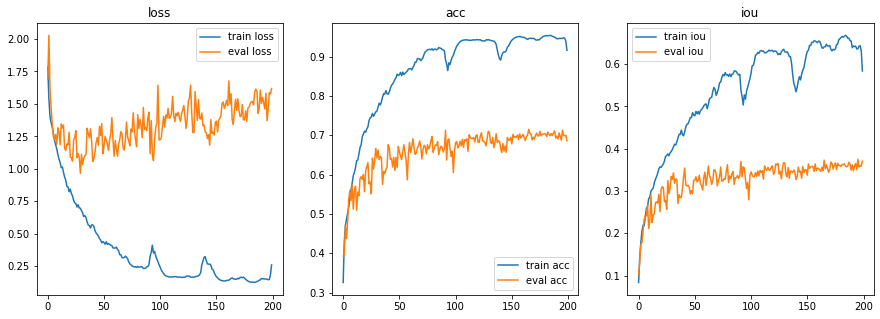

In [17]:
metrics.plot()

### Test set

We'll use the validation data as test set, due to the lack of images. We can rest assure that these images did not affect the weights of the model, so there is no problem using these, just to check some metrics.

In [ ]:
X_test, y_test = X_val, y_val
X_test = [Image.open(x) for x in X_test]
y_test = [Image.open(y) for y in y_test]

y_pred = []
unet.eval()
for im in X_test:
  x = to_im_tensor(im, get_transforms()).unsqueeze(0).to(device)
  out = unet(x)
  out = torch.argmax(out, axis=1).squeeze(0)
  out = out.detach().cpu().float().numpy()
  y_pred.append(cv2.resize(out, im.size))

test_set = list(zip(X_test, y_test, y_pred))

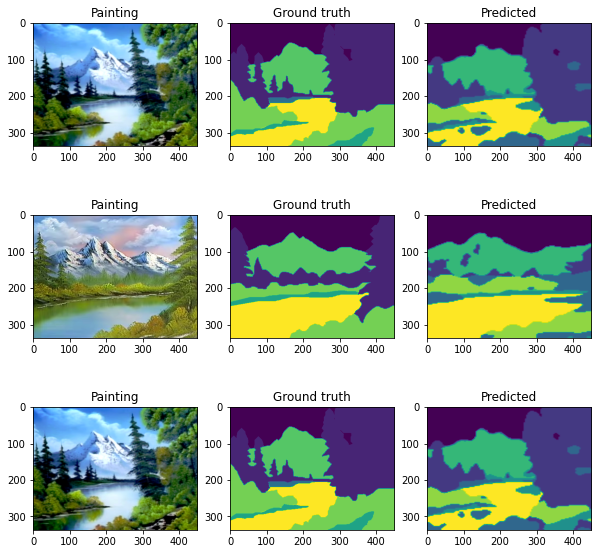

In [19]:
num_tests = 3

f, ax = plt.subplots(num_tests, 3, figsize=(10, 10))

for i in range(num_tests):
  im, gt, pred = random.choice(test_set)

  ax[i, 0].set_title('Painting')
  ax[i, 0].imshow(im)

  ax[i, 1].set_title('Ground truth')
  ax[i, 1].imshow(gt)

  ax[i, 2].set_title('Predicted')
  ax[i, 2].imshow(pred)